# LJ Potential Benchmarking

Benchmarking TMol LJ-potential implementation.

In [1]:
import importlib
import logging
importlib.reload(logging)
logging.basicConfig(level=logging.INFO)

logging.getLogger("rosetta").setLevel(logging.WARNING)

In [2]:
import toolz
from toolz import first, merge

In [3]:
import numba
import numba.cuda

numba.config.NUMBA_NUM_THREADS = 8

In [4]:
import tmol.tests.data

In [5]:
import tmol.utility.numba
from tmol.utility.reactive import reactive_attrs, reactive_property

from tmol.tests.benchmark import make_fixture, make_subfixture, stat_frame, subfixture

In [6]:
import tmol.score

In [7]:
import torch

In [8]:
import functools

In [9]:
decoys = tmol.tests.data.structures_bysize()

In [26]:
from itertools import product

import tmol.score.ljlk.numba_potential

def benchmark_decoys(decoys):
    stats = []
    
    for n, d in decoys.items():
        fixture = make_fixture("lj", stats.append, nres=len(d.tmol_system.residues), natoms=len(d.tmol_coords), model=n)
        
        if fixture.extra_info["nres"] > 400:
            pass
            
        logging.info(f"{n}")
        
        score_graph = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system)

        ljlk_resolver = score_graph.param_resolver
        ljlk_atom_types = ljlk_resolver.type_idx(score_graph.atom_types)

        coords = score_graph.coords.detach()[0]
        types = torch.tensor(ljlk_atom_types[0])
        path_length = torch.tensor(score_graph.bonded_path_length[0].astype("u1"))
        ibd = score_graph.interblock_distance.min_dist[0]
        
        cpu_scores = {}
        
        for parallel, blocked in product((True, False), (True, False)):
            n = ".cpu" + ("_parallel" if parallel else "") + ("_blocked" if blocked else "")
            
            @make_subfixture(fixture, n, platform="cpu", parallel=parallel, blocked=blocked)
            def score():
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords,
                    types,
                    path_length,

                    ljlk_resolver.pair_params.lj_sigma,
                    ljlk_resolver.pair_params.lj_switch_slope,
                    ljlk_resolver.pair_params.lj_switch_intercept,
                    ljlk_resolver.pair_params.lj_coeff_sigma12,
                    ljlk_resolver.pair_params.lj_coeff_sigma6,
                    ljlk_resolver.pair_params.lj_spline_y0,
                    ljlk_resolver.pair_params.lj_spline_dy0,

                    ljlk_resolver.global_params.lj_switch_dis2sigma,
                    ljlk_resolver.global_params.spline_start,
                    ljlk_resolver.global_params.max_dis,
                    parallel=parallel,
                    block_distances=ibd if blocked else None
                ).sum()
            cpu_scores[n] = score
            
        logging.info(f"cpu: {cpu_scores}")
         
        
        score_graph_c = tmol.score.CartesianTotalScoreGraph.build_for(d.tmol_system, device=torch.device("cuda"))
        ljlk_resolver_c = score_graph_c.param_resolver
        coords_c = score_graph_c.coords.detach()[0]
        types_c = types.cuda()
        path_length_c = path_length.cuda()
        ibd_c = score_graph_c.interblock_distance.min_dist[0]
                
        inputs = dict(
            atom_types = types_c,
            bonded_path_length = path_length_c,
        )
        preorg_inputs = {n : numba.cuda.as_cuda_array(p) for n, p in inputs.items() }
        
        params = dict(
         lj_sigma=           ljlk_resolver_c.pair_params.lj_sigma,
         lj_switch_slope=           ljlk_resolver_c.pair_params.lj_switch_slope,
         lj_switch_intercept=           ljlk_resolver_c.pair_params.lj_switch_intercept,
         lj_coeff_sigma12=           ljlk_resolver_c.pair_params.lj_coeff_sigma12,
         lj_coeff_sigma6=           ljlk_resolver_c.pair_params.lj_coeff_sigma6,
         lj_spline_y0=           ljlk_resolver_c.pair_params.lj_spline_y0,
         lj_spline_dy0=           ljlk_resolver_c.pair_params.lj_spline_dy0,
            
          lj_switch_dis2sigma=          ljlk_resolver_c.global_params.lj_switch_dis2sigma,
          spline_start=          ljlk_resolver_c.global_params.spline_start,
          max_dis=          ljlk_resolver_c.global_params.max_dis,
        )
        
        preorg_params = {n : numba.cuda.as_cuda_array(p) for n, p in params.items() }
        cuda_scores = {}
        
        for preorg, blocked in product((True, False), (True, False)):
            n = ".cuda" + ("_preorg" if preorg else "") + ("_blocked" if blocked else "")
            
            @make_subfixture(fixture, n, platform="cpu", parallel=parallel, blocked=blocked)
            def score():
                return tmol.score.ljlk.numba_potential.lj_intra_kernel(
                    coords_c,
                    **merge(inputs, preorg_params if preorg else params),
                    block_distances=ibd_c if blocked else None
                ).sum()
            cuda_scores[n] = score
                
            
        logging.info(f"cuda_scores: {cuda_scores}")
        
    return stats

In [27]:
import importlib
importlib.reload(tmol.score.ljlk.numba_potential)

res = benchmark_decoys(decoys)

INFO:root:BYSIZE_400_RES_6AZU
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-84.5055), '.cpu_parallel': tensor(-84.5055), '.cpu_blocked': tensor(-84.5055), '.cpu': tensor(-84.5055)}
INFO:root:cuda_scores: {'.cuda_preorg_blocked': tensor(-84.5055, device='cuda:0'), '.cuda_preorg': tensor(-84.5055, device='cuda:0'), '.cuda_blocked': tensor(-84.5055, device='cuda:0'), '.cuda': tensor(-84.5055, device='cuda:0')}
INFO:root:BYSIZE_200_RES_5MM8
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-9.2401), '.cpu_parallel': tensor(-9.2401), '.cpu_blocked': tensor(-9.2401), '.cpu': tensor(-9.2401)}
INFO:root:cuda_scores: {'.cuda_preorg_blocked': tensor(-9.2401, device='cuda:0'), '.cuda_preorg': tensor(-9.2401, device='cuda:0'), '.cuda_blocked': tensor(-9.2401, device='cuda:0'), '.cuda': tensor(-9.2401, device='cuda:0')}
INFO:root:BYSIZE_250_RES_5N5G
INFO:root:cpu: {'.cpu_parallel_blocked': tensor(-154.1009), '.cpu_parallel': tensor(-154.1009), '.cpu_blocked': tensor(-154.1009), '.cpu': tensor(-154

In [32]:
import pandas
import seaborn
from matplotlib import pyplot

In [33]:
dat = stat_frame(res)

dat = pandas.concat(
    (
        dat,
        pandas.merge(
            dat,
            dat.query("name == 'lj.cpu_blocked'").groupby("nres").time.mean().rename("serial_cpu_mean").to_frame(),
            left_on="nres",
            right_index=True
        ).eval("time / serial_cpu_mean").rename("serial_cpu_relative")
    ),
    axis=1
)

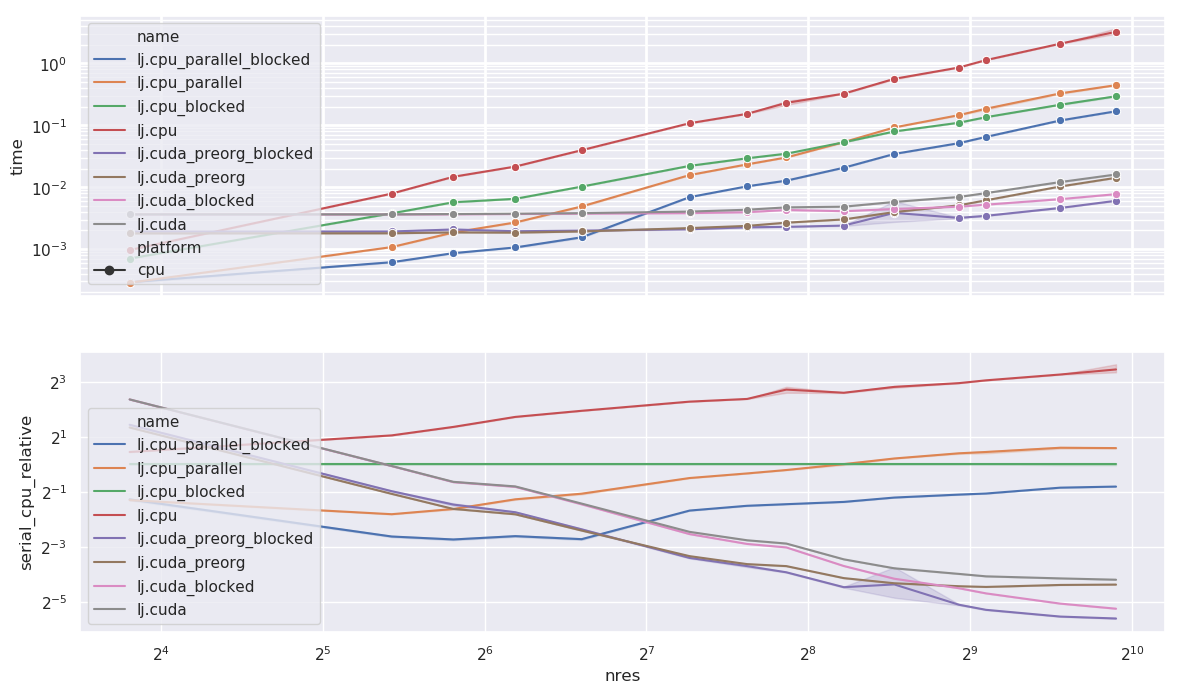

In [34]:
f, (a1, a2) = pyplot.subplots(2, sharex=True)

pyplot.xscale("log", basex=2)

pyplot.sca(a1)
pyplot.yscale("log", basey=10)
pyplot.grid(True, "major", linewidth=2)
pyplot.grid(True, "minor")
seaborn.lineplot("nres", "time", data=dat, hue="name", style="platform", markers=True)

pyplot.sca(a2)
pyplot.yscale("log", basey=2)
seaborn.lineplot("nres", "serial_cpu_relative", data=dat, hue="name", markers=True)

In [35]:
(
    dat.query("name=='lj.cuda_preorg_blocked'")
    .groupby("nres")[["serial_cpu_relative", "time"]]
    .describe().reorder_levels((1, 0), axis=1)[["mean", "max", "std"]]
)

mean                           max            \
     serial_cpu_relative      time serial_cpu_relative      time   
nres                                                               
14              2.724251  0.001921            3.873738  0.002731   
43              0.509432  0.001928            0.720021  0.002725   
56              0.363168  0.002075            0.571269  0.003264   
73              0.299458  0.001945            0.424817  0.002759   
97              0.194586  0.001990            0.270173  0.002763   
154             0.094478  0.002091            0.129711  0.002870   
197             0.076860  0.002255            0.164445  0.004824   
233             0.065769  0.002288            0.098651  0.003433   
298             0.045156  0.002399            0.062708  0.003331   
370             0.048417  0.003850            0.074827  0.005949   
488             0.028992  0.003195            0.044793  0.004936   
548             0.025493  0.003450            0.031003  0.004195   
753             0.021505  0.004623            0.025126  0.005401   
956             0.020486  0.006034            0.023076  0.006797   

                     std            
     serial_cpu_relative      time  
nres                                
14              0.387500  0.000273  
43              0.073414  0.000278  
56              0.089522  0.000511  
73              0.042285  0.000275  
97              0.026532  0.000271  
154             0.012283  0.000272  
197             0.017269  0.000507  
233             0.006056  0.000211  
298             0.005069  0.000269  
370             0.022880  0.001819  
488             0.002856  0.000315  
548             0.001645  0.000223  
753             0.000911  0.000196  
956             0.000842  0.000248